## Summarizing Interview Data : Sentiment Analysis, Topic Modeling, Open AI

### Sentiment Analysis

In [1]:
# Import Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import docx
from pathlib import Path

In [2]:
# Download the stopwords corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avales\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avales\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Transcript Paths
folder_path = Path("C:/Users/avales/OneDrive/Desktop/AI in Healthcare/High Risk Project/Documents/")

# Docx documents in folder
transcript_paths = list(folder_path.glob("*.docx"))

# Create Empty List
data = []

# Preprocessing
stop_words = set(stopwords.words('english'))

# For each document look at the paragraphs and token words and remove stop words
for transcript_path in transcript_paths:
    doc = docx.Document(transcript_path)
    text = ""
    for para in doc.paragraphs:
        text += para.text + "\n"
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    data.append(" ".join(filtered_words))

# Sentiment Analysis
sentiments = []
for text in data:
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0:
        sentiments.append("Positive")
    elif sentiment_score < 0:
        sentiments.append("Negative")
    else:
        sentiments.append("Neutral")

In [6]:
sentiments

['Positive', 'Positive', 'Positive', 'Positive']

The transcripts provided were majority positive. Patients are reporting a positive experience in these interviews. 

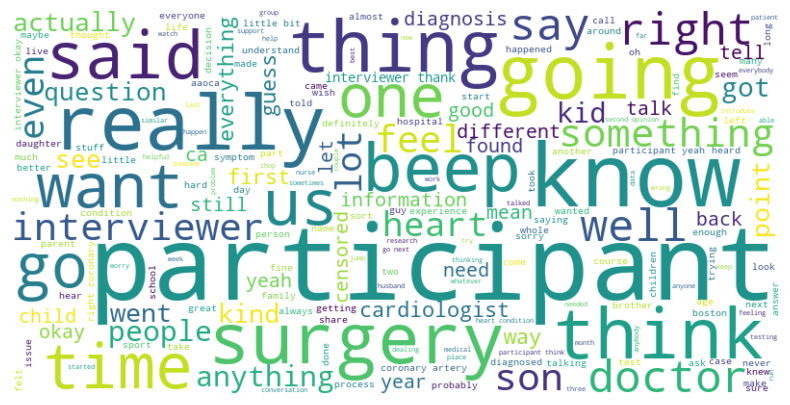

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Store Positive Phrases
positive_phrases = []

# Iterations
for text in data:
    blob = TextBlob(text)
    sentences = blob.sentences
    for sentence in sentences:
        # Sentiment Scores for each sentence
        sentiment_score = sentence.sentiment.polarity
        # Positive sentiments get appended
        if sentiment_score > 0:
            positive_phrases.append(str(sentence))

# Single String for Word Cloud
positive_text = ' '.join(positive_phrases)

# World Cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(positive_text)

# Display Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Common positive words include particpant, surgery, time, doctor, kind, right

### Topic Modeling

In [15]:
# Topic Modeling (LDA)
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(data)
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_model.fit(tfidf)

LatentDirichletAllocation(n_components=3, random_state=42)

In [19]:
# Top 15 words per topic
feature_names = vectorizer.get_feature_names_out()
n_top_words = 15

for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx+1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Topic 1:
frustrating inaudible coach curious wife correct strong original ultrasound wanting hockey line cleared affirmative coast

Topic 2:
inaudible arrest wife remember initial biggest incident curious symptom coach helps hockey guard tiny coaches

Topic 3:
data cardiology emotions known outcomes scare local exercise general pediatric emotionally practice smoke afraid die



Themes between the four documents include frustrating, curious, emotions, data. 

In [20]:
# Topic Distribution
topic_distribution = lda_model.transform(tfidf)

# Topic Distribution per Doc. 
for doc_idx, doc_topics in enumerate(topic_distribution):
    print(f"Document {doc_idx+1}:")
    for topic_idx, topic_prob in enumerate(doc_topics):
        print(f"Topic {topic_idx+1}: {topic_prob:.4f}")
    print()

Document 1:
Topic 1: 0.0306
Topic 2: 0.0324
Topic 3: 0.9370

Document 2:
Topic 1: 0.0263
Topic 2: 0.9462
Topic 3: 0.0275

Document 3:
Topic 1: 0.0278
Topic 2: 0.9432
Topic 3: 0.0290

Document 4:
Topic 1: 0.0283
Topic 2: 0.0293
Topic 3: 0.9424



Documents have different themes that can be expressed. 

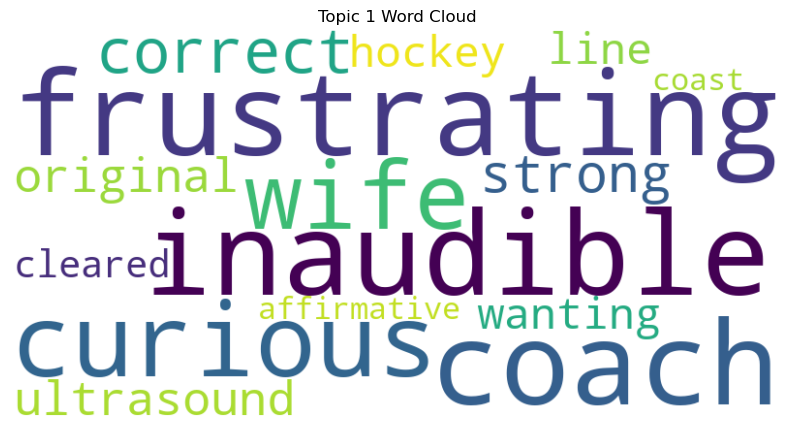

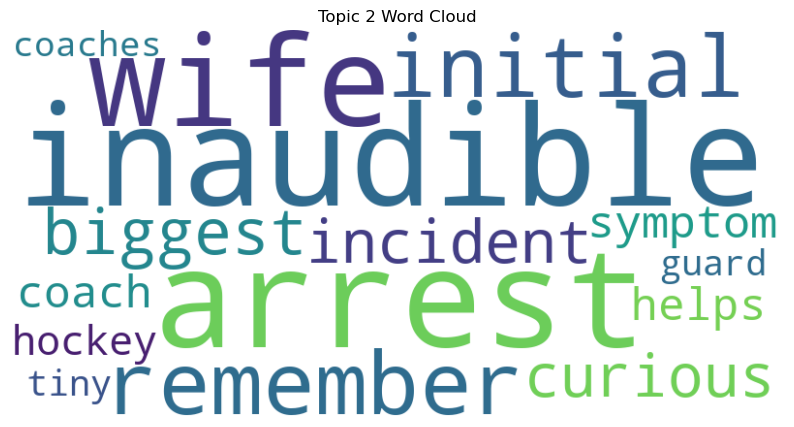

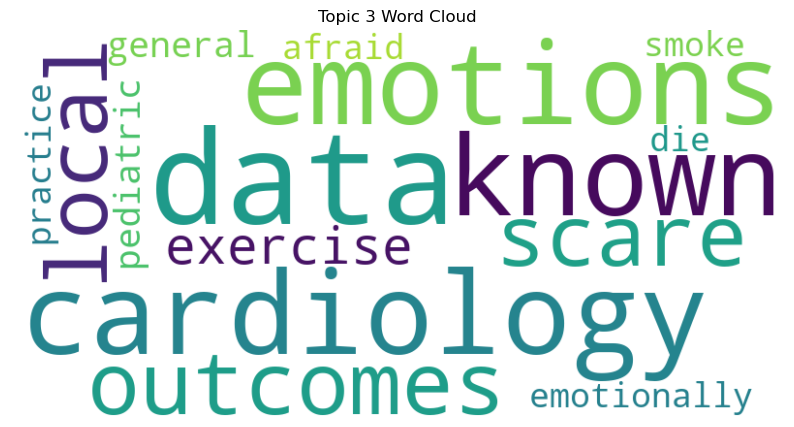

In [21]:
# Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Topic Word Clouds
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_top_words - 1:-1]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_idx+1} Word Cloud")
    plt.axis('off')
    plt.show()

### Outcomes and Key word matching

In [33]:
from nltk.stem import PorterStemmer # Stem words for plurals

# Folder Path
folder_path = Path("C:/Users/avales/OneDrive/Desktop/AI in Healthcare/High Risk Project/Documents/")

# File List
transcript_paths = list(folder_path.glob("*.docx"))

# Word Stemming
stemmer = PorterStemmer()

# Outcome Words
outcome_keywords = ["recovery", "recover", "recovers", "recovered", "recovering",
                    "treatment success", "complication", "complications",
                    "improvement", "improve", "improves", "improved", "improving",
                    "discharge", "discharged", "discharges", "road block", "road blocks",
                   "delayed", "delays", "delay", "outcome", "outcomes","satisfied", "satisfaction",
                   "harmful", "harm", "harmed", "favorable", "better", "experience", "experienced", 
                    "diagnosis","surgeon","times", "times", "health","healthy", "ill", "sick"
                   ]

# Extract Keywords
def extract_outcome_sentences(text):
    sentences = text.split(".")
    outcome_sentences = []
    for sentence in sentences:
        # Stem words in the sentence for matching
        stemmed_sentence = [stemmer.stem(word) for word in sentence.lower().split()]
        if any(stemmer.stem(keyword) in stemmed_sentence for keyword in outcome_keywords):
            outcome_sentences.append(sentence.strip())
    return outcome_sentences

# Iterate over transcripts
outcomes = []
for transcript_path in transcript_paths:
    doc = docx.Document(transcript_path)
    text = ""
    for para in doc.paragraphs:
        text += para.text + "\n"
    outcome_sentences = extract_outcome_sentences(text)
    outcomes.extend(outcome_sentences)

# Sentence with outcomes are printed 
for idx, sentence in enumerate(outcomes, start=1):
    print(f"Sentence {idx}: {sentence}")


Sentence 1: Participant 2004:
When you hear us talking about this, you aren't going to hear -- the negative effects were emotional and that things were not done well at times
Sentence 2: Actually, two of them, some of you were talking about were -- two of them we were dealing with at the same time and it was in the midst of COVID
Sentence 3: " Hopefully, I will hear that in some time in future
Sentence 4: To be honest with you, by the time he was done, he had both the right and the left surgically repaired
Sentence 5: You just have to leave him like that and then let the age take the course or let the time take the course
Sentence 6: " I mean, we know he's sitting on the pawn, but then how do you get that fixed?
Participant 1002:
It's a real pain actually to -- It's not like they're abnormal, they're very healthy kids
Sentence 7: She is high energy all the time and she is not restricted according to the doctors, which is comforting, but it also
Sentence 8: I do my best and trust that i

### Gaps in Care and Key Word Matching

In [34]:
# Words Related to Gaps in Care (with variations)
gap_keywords = ["gap", "gaps", "care gap", "care gaps", "deficiency", "deficiencies", 
                "lack", "missing", "needs improvement", "improve", "improvement", 
                "lacking", "inadequate", "insufficient", "shortcoming", "shortcomings", "problems", 
               "problematic"
               ]

# Function to extract sentences containing gap-related keywords
def extract_gap_sentences(text):
    sentences = text.split(".")
    gap_sentences = []
    for sentence in sentences:
        # Stem words in the sentence for matching
        stemmed_sentence = [stemmer.stem(word) for word in sentence.lower().split()]
        if any(stemmer.stem(keyword) in stemmed_sentence for keyword in gap_keywords):
            gap_sentences.append(sentence.strip())
    return gap_sentences

# Iterate through each transcript
gaps = []
for transcript_path in transcript_paths:
    doc = docx.Document(transcript_path)
    text = ""
    for para in doc.paragraphs:
        text += para.text + "\n"
    gap_sentences = extract_gap_sentences(text)
    gaps.extend(gap_sentences)

# Print extracted gap-related sentences
for idx, sentence in enumerate(gaps, start=1):
    print(f"Sentence {idx}: {sentence}")


Sentence 1: There is no resuscitation or it is actually not a problem anymore
Sentence 2: But then again, with this one, lately, when we have shown him in Austin, one of the doctors, he really did not indicate a serious problem or he did not indicate something is majorly wrong or something, so we still have a little bit of doubt there, but then I know for sure there is definitely anomalous artery for him, but again, we don't know what is in store for his own future
Sentence 3: "
Participant 2003:
Like Wolff-Parkinson-White now, it's like when my brother had the surgery 40 years ago, it was very rare, but now it's like a routine surgery to fix Wolff-Parkinson-White, no problem
Sentence 4: They knew that her heart was having a problem
Sentence 5: Just a nasal congestion, nasal virus can get to the heart, and penetrate the heart and cause problems
Sentence 6: That was still causing her problems
Sentence 7: " The problem with this is it's not a slow thing, like okay, this happened
Sentence

### Summary

In [23]:
# API Key
import openai
openai.api_key = '' # This has been removed, you will need to add you own

In [41]:
import openai
import docx

# Contents of word docs
def read_docx(file_path):
    doc = docx.Document(file_path)
    full_text = ""
    for paragraph in doc.paragraphs:
        full_text += paragraph.text + "\n"
    return full_text

# Split into smaller chunks
def split_text(text, max_tokens):
    chunks = []
    current_chunk = ""
    token_count = 0
    for word in text.split():
        if token_count + len(word.split()) > max_tokens:
            chunks.append(current_chunk)
            current_chunk = ""
            token_count = 0
        current_chunk += word + " "
        token_count += len(word.split())
    if current_chunk:
        chunks.append(current_chunk)
    return chunks

# List of file paths to the Word documents
file_paths = [
    r'C:\Users\avales\OneDrive\Desktop\AI in Healthcare\High Risk Project\documents\05-03-2021_AAOCA_Deidentified_EG_parents.docx',
    r'C:\Users\avales\OneDrive\Desktop\AI in Healthcare\High Risk Project\documents\06-21-2021_AAOCA_Deidentified_EG_parents.docx',
    r'C:\Users\avales\OneDrive\Desktop\AI in Healthcare\High Risk Project\documents\08-03-2021_Deidentified_EG_AAOCA_Parents_RL.docx',
    r'C:\Users\avales\OneDrive\Desktop\AI in Healthcare\High Risk Project\documents\10-05-21_Deidentified_Parents.docx'
]

# Read the contents of each Word document
texts = [read_docx(file_path) for file_path in file_paths]

# One Time response
themes = []
for text in texts:
    text_chunks = split_text(text, max_tokens=400)  # max tokens
    chunk_themes = []
    for chunk in text_chunks:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {
                    "role": "user",
                    "content": f"The text to be summarized is: {chunk}\nPlease provide five themes based on the summary.You are an expert at summarizing medical transcript. "
                }
            ]
        )
        chunk_themes.append(response.choices[0].message['content'])
    themes.append('\n'.join(chunk_themes))

# Print the themes generated by the model
for i, theme in enumerate(themes):
    print(f"Themes for document {i+1}:\n{theme}\n")


Themes for document 1:
1. Communication and Terminology: Participants discussed how they refer to the condition, with some using medical acronyms and others simplifying the terminology to make it easier for others to understand.

2. Variability in Anatomical Presentation: The participants shared that the anomalous coronary artery could be located on the left or right side, leading to different anatomical presentations and variations in the condition.

3. Lack of Awareness: Many participants noted that outside of medical professionals, people are often unaware of the condition and its complexities, leading them to simplify the terminology when discussing it with others.

4. Family Communication: Within their families, participants tend to use simpler language to refer to the condition, focusing on the fact that their loved one has a heart condition rather than specific medical terms.

5. Importance of Keeping it Simple: The consensus among participants was that simplifying the language 

### Combination Summary

In [25]:
from collections import Counter
import openai
import docx

# Function to read the contents of a Word document
def read_docx(file_path):
    doc = docx.Document(file_path)
    full_text = ""
    for paragraph in doc.paragraphs:
        full_text += paragraph.text + "\n"
    return full_text

# Function to split text into smaller chunks
def split_text(text, max_tokens):
    chunks = []
    current_chunk = ""
    token_count = 0
    for word in text.split():
        if token_count + len(word.split()) > max_tokens:
            chunks.append(current_chunk)
            current_chunk = ""
            token_count = 0
        current_chunk += word + " "
        token_count += len(word.split())
    if current_chunk:
        chunks.append(current_chunk)
    return chunks

# List of file paths to the Word documents
file_paths = [
    r'C:\Users\avales\OneDrive\Desktop\AI in Healthcare\High Risk Project\documents\05-03-2021_AAOCA_Deidentified_EG_parents.docx',
    r'C:\Users\avales\OneDrive\Desktop\AI in Healthcare\High Risk Project\documents\06-21-2021_AAOCA_Deidentified_EG_parents.docx',
    r'C:\Users\avales\OneDrive\Desktop\AI in Healthcare\High Risk Project\documents\08-03-2021_Deidentified_EG_AAOCA_Parents_RL.docx',
    r'C:\Users\avales\OneDrive\Desktop\AI in Healthcare\High Risk Project\documents\10-05-21_Deidentified_Parents.docx'
]

# Read the contents of each Word document and combine into a single text
combined_text = ""
for file_path in file_paths:
    combined_text += read_docx(file_path) + "\n"

# Split the combined text into smaller chunks
text_chunks = split_text(combined_text, max_tokens=400)  # max tokens/would like more but cannot process

# Themes List
themes = []

# Generate themes for each text chunk
for chunk in text_chunks:
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "user",
                "content": f"The text to be summarized is: {chunk}\nPlease provide five themes based on the summary. You are an expert at summarizing medical transcript."
            }
        ]
    )
    themes.append(response.choices[0].message['content'])

# Theme frequency count
theme_counter = Counter(themes)

# Five most common themes
top_five_themes = theme_counter.most_common(5)

# Themes
final_themes = [theme[0] for theme in top_five_themes]

# Print the final themes
print("Top five themes based on the combined text:")
for i, theme in enumerate(final_themes):
    print(f"Theme {i+1}: {theme}")


Top five themes based on the combined text:
Theme 1: Themes based on the summary:

1. Use of Acronyms: Participants commonly refer to the heart condition as AAOCA, ALCA, or simply anomalous right coronary artery, using acronyms to simplify the lengthy medical terms.

2. Lack of Understanding by Others: Participants express frustration in discussing the condition with others, including medical practitioners, who may not be familiar with the terminology or specifics of the condition.

3. Keeping it Simple: Participants opt to keep the discussion of the condition simple, using generic terms like "heart condition" or "his heart condition" when talking about it with others, including close family members.

4. Personalized Terminology: Some participants use more specific terminology based on the location of the anomaly, such as anomalous right coronary from the left sinus of Valsalva or anomalous right coronary artery, tailored to their individual situation.

5. Communication Challenges: The